In [1]:
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [4]:
from utils import read_dataset, plot_confusion_matrix
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS

In [5]:
def prepare_dataset(all_trials, class_columns):
    X = []
    Y = []

    for trial in all_trials:
        X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
        Y.append(np.argmax(np.array(trial[class_columns].iloc[0])))

    X = np.array(X)
    Y = np.array(Y)

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    attr_means = X_train.reshape(-1, X_train.shape[-1]).mean(axis=0)
    attr_std = X_train.reshape(-1, X_train.shape[-1]).std(axis=0)
    X_train_scaled = (X_train - attr_means) / attr_std
    X_val_scaled = (X_val - attr_means) / attr_std

    X_train = torch.from_numpy(X_train_scaled).cuda()
    X_val = torch.from_numpy(X_val_scaled).cuda()
    Y_train = torch.from_numpy(Y_train).type(torch.LongTensor).cuda()
    Y_val = torch.from_numpy(Y_val).type(torch.LongTensor).cuda()

    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=640, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader

In [22]:
def train_across_lengths(train_loader, val_loader):
    
    input_dim = 16    # input dimension
    first_hidden_dim = 12  # hidden layer dimension
    second_hidden_dim = 6     # number of hidden layers
    output_dim = 3   # output dimension

    num_epochs = 200
    steps = [1, 2, 3]

    all_loss = []
    all_acc = []

    for step in steps:
        sequence_loss = []
        sequence_acc = []

        for seed in [0, 33, 72, 100, 150, 250]:
            np.random.seed(seed)
            torch.cuda.manual_seed_all(seed)

            seed_loss = []
            seed_acc = []

            model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
            model = model.cuda()

            # Cross Entropy Loss 
            error = nn.CrossEntropyLoss().cuda()

            # Adam Optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


            for epoch in  tqdm(range(num_epochs)):

                epoch_loss = 0

                for i, (x, y) in enumerate(train_loader):

                    x = Variable(x[:, ::step, :])
                    y = Variable(y)
                    # Clear gradients
                    optimizer.zero_grad()

                    # Forward propagation
                    y_hat = model(x)

                    # Calculate softmax and cross entropy loss
                    loss = error(y_hat, y)

                    # Calculating gradients
                    loss.backward()

                    # Update parameters
                    optimizer.step()

                    epoch_loss += loss.item()

                seed_loss.append(epoch_loss / len(train_loader))

                correct = 0
                total = 0

                for x_val, y_val in val_loader:
                    x_val = Variable(x_val[:, ::step, :])
                    y_hat = model(x_val)

                    predicted = torch.max(y_hat.data, 1)[1]

                    total += y_val.size(0)
                    correct += (predicted == y_val).sum()

                accuracy = 100 * correct / float(total)

                seed_acc.append(accuracy.item())

            sequence_loss.append(seed_loss)
            sequence_acc.append(seed_acc)
        all_loss.append(sequence_loss)
        all_acc.append(sequence_acc)
        
    return all_acc, all_loss

In [23]:
def plot_timeseries(timeseries, labels):
    plt.figure(figsize=(11, 7))
    for length, ts_item in zip(labels, timeseries):
        plt.errorbar(np.arange(timeseries.shape[-1]), ts_item.mean(axis=0), yerr=ts_item.std(axis=0), 
                     label=str(length))
    plt.legend()

# MASS TRIALS

In [24]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader = prepare_dataset(all_trials, MASS_CLASS_COLS)
all_loss, all_acc = train_across_lengths(train_loader, val_loader)

all_loss = np.array(all_loss)
all_acc = np.array(all_acc)

100%|██████████| 200/200 [00:25<00:00,  8.03it/s]


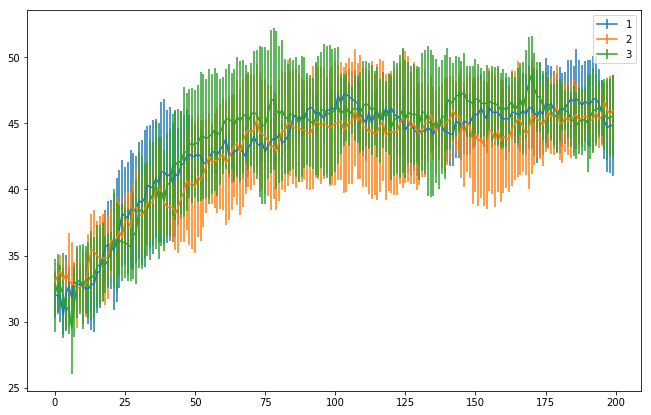

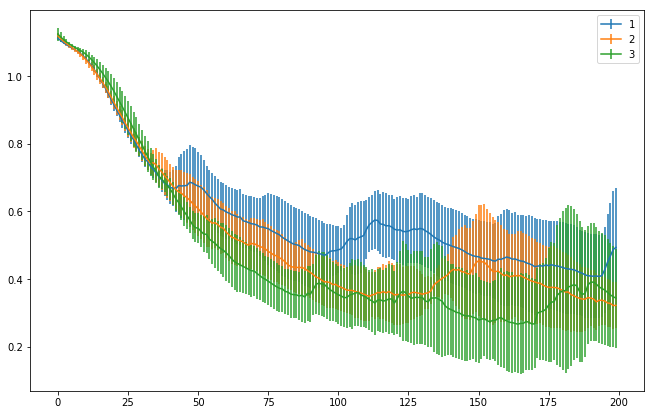

In [25]:
plot_timeseries(all_loss, [1, 2, 3])
plot_timeseries(all_acc, [1, 2, 3])

# FORCE

In [26]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader = prepare_dataset(all_trials, FORCE_CLASS_COLS)
all_loss, all_acc = train_across_lengths(train_loader, val_loader)

all_loss = np.array(all_loss)
all_acc = np.array(all_acc)

100%|██████████| 200/200 [00:26<00:00,  7.46it/s]


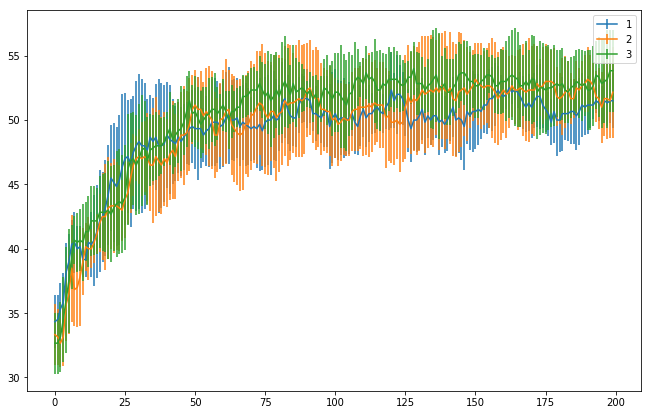

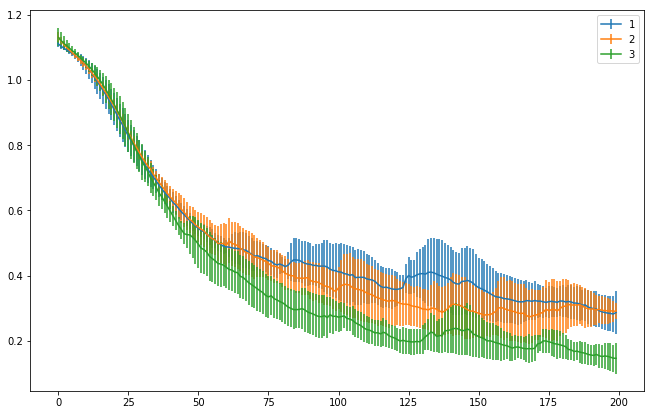

In [27]:
plot_timeseries(all_loss, range(1, 4))
plot_timeseries(all_acc, range(1, 4))